In [209]:
import numpy as np
from scipy.special import gammainc, gamma
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.integrate import quad
from scipy.stats import poisson
from tqdm import tqdm   
from random import choices
from collections import Counter
from scipy.optimize import curve_fit

## Juan Notes:
* I would like a docstring for how singleAtom works. We've been using the google standard for dev on the cspy project, looks like we'll be adopting it as a lab so use that.
    - google standard styleguide, info on docstrings is section 3.8 : http://google.github.io/styleguide/pyguide.html
    - google standard examples : https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html
* units for values set?
* the first term in your lambda function is causing decays of counts to zero. They need to decay into the background rate
* I like what you've done here, but I would like to be able to understand at a glance. Could you put a latex explanation of the math you're doing up here?

The rate of photon emission from a single atom is a poisson distribution centerred around the mean number of counts, rateSingleAtom*recordTime.
However, the readout beams can heat the atom in the trap and so there is a finite lifetime of the trap
$$\frac{e^{-t/\tau}}{\tau}$$ where $\tau$ is the lifetimeOfTrap.

The function singleAtom finds the new probability distribution integrating the lifetime with the poisson distribution. 

We then have to convolve the single atom rate with the background rate because the background rate is always present. From wikipedia:  

"the probability mass function or probability density function of a sum of random variables is the convolution of their corresponding probability mass functions or probability density functions respectively"

the sum here is the background rate and the single atom rate.

In [298]:
#define the variables that determine how many photons are released
recordTime = .003
rateSingleAtom = 145000
rateBackground = 10000
lifetimeOfTrap = 1

#up to this many photons
countEnd = 700
xx = np.arange(countEnd)
#the background is just a poisson distribution
probDistBack = poisson.pmf(xx,recordTime*rateBackground)
#the single atom is a poisson distribution with a lifetime of 1/e 
def singleAtom(recordTime,rate,lifeTime,xx):
    """
    Args:
        recordTime: the time that the measurment beams are active(seconds).
        rate: the rate that the single atom emits photons(photons/second)
        xx: an array of integers that are the possible photon counts to measure
    Returns:
        an array of probabilities to measure the photon count given the paramaters.

    """ 
    prob = []
    for i in tqdm(xx):
        #take the integral of the lifetime and the poisson dist 
        val = quad(
            lambda t,r,n,ts,tau:np.exp(-t/tau)/tau*poisson.pmf(n,r*t),
            0,
            recordTime,
            args = (rate,i,recordTime, lifeTime) 
        )[0] 
        prob.append(val+np.exp(-recordTime/lifeTime)*poisson.pmf(i,rate*recordTime)) 
    #return the prob dist for all of the photon counts in xx
    return prob


#get the distribution, the integrals take longer then the rest of the code
probDistSingle = singleAtom(recordTime,rateSingleAtom,lifetimeOfTrap,xx)
#now convolve with background rate
probDistSingle = np.convolve(probDistSingle,probDistBack,'same')


100%|██████████| 700/700 [00:07<00:00, 92.49it/s]


In [299]:
#get a histogram with N datapoints
hist = [] 
N = 5000
population = [False,True] #false is no atom, true is single atome
#the prob of loading an atom
weights = [.5,.5]
samples = choices(population,weights,k = N)

for i in samples:
    if not i:
        #do background rate
        hist.append(choices(xx,probDistBack)[0])
    else:
        #do single atom rate
        hist.append(choices(xx,probDistSingle)[0])

We have the histogram, and I am just going to fit a gaussian curve to the historgram to find out the mean number of counts for each distribution

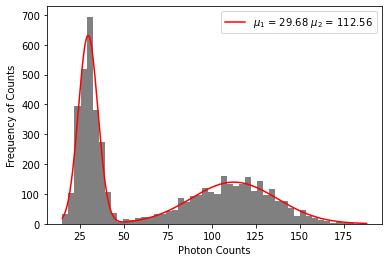

Background mean(rate*time): 30.00


In [306]:
#the function as the addition of two gaussian curves
def gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))


#the histogram and the bin heights and centers that will be used for fitting
bin_heights, bin_borders, _ = plt.hist(hist,50)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
#fit with guess p0
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[700, 30, 1, 150, 125, 5])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label=r"$\mu_1$ = %.2f $\mu_2$ = %.2f"%(popt[1],popt[4]),color = 'r')
plt.hist(hist,50,color = 'gray')
plt.legend()
plt.xlabel("Photon Counts")
plt.ylabel("Frequency of Counts")
plt.show()
print ("Background mean(rate*time): %.2f" %(recordTime*rateBackground))  

The integration takes a long time, this is my attempt at simulating atom loss during a measurement many times. Instead of taking an integral for each photon count, take the probability of the atom leaving the trap at time t for t from 0 to recorded time. At each of the steps change the probability that the atom will leave, then count up the amount of photons according to the status of the atom at that step(rate/totalTimeSteps). I tried taking a new sample from each dist at each step but that only created two very distinct gaussian dist far apart. I think that is interesting and it might have something to do with normal distrbutions and sample numbers. 

In [301]:
totalTimeSteps = 100
time_bins = np.linspace(0,recordTime,totalTimeSteps)
#the dist of the atom in the trap 
lifetimeOfTrap = 1
time_dist = [np.exp(-t/lifetimeOfTrap) for t in time_bins]
#so given each time step, there is a chance 1-time_dist[step] of leaving the trap
#each step there is a poisson dist of photons emiited that is divided by nTimeSteps

In [302]:
hist = [] 
N = 5000
population = [0,1] #0 is no atom, 1 is single atome
#the prob of loading an atom
weights = [.5,.5]
samples = choices(population,weights,k = N)

for i in tqdm(samples):
    if i == 0:
        #do background rate
        hist.append(choices(xx,probDistBack)[0])
    else:
        #do single atom rate
        val = 0
        left = False #the check on if the atom has left the trap
        choiceSingle = choices(xx,probDistSingle)[0] 
        choiceBack = choices(xx,probDistBack)[0]
        #step through the times
        for i in range(totalTimeSteps): 
            #determine if atom left trap from the prob dist 
            if choices([False,True],[1-time_dist[i],time_dist[i]])[0] and not left:
                #we do the single atom rate
                val += choiceSingle/totalTimeSteps
                
            else:
                left = True 
                #the background rate
                val += choiceBack/totalTimeSteps               
        hist.append(val) 

100%|██████████| 5000/5000 [00:01<00:00, 3060.23it/s]


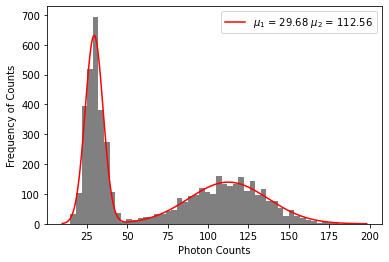

Background mean(rate*time): 30.00


In [303]:


bin_heights2, bin_borders2, _ = plt.hist(hist,50)
bin_centers2 = bin_borders2[:-1] + np.diff(bin_borders2) / 2
popt, pcov = curve_fit(gaussian, bin_centers2, bin_heights2, p0=[700, 35, 1, 100, 125, 1])
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label=r"$\mu_1$ = %.2f $\mu_2$ = %.2f"%(popt[1],popt[4]),color = 'r')
plt.hist(hist,50,color = 'gray')
plt.legend()
plt.xlabel("Photon Counts")
plt.ylabel("Frequency of Counts")
plt.show()
print ("Background mean(rate*time): %.2f" %(recordTime*rateBackground)) 